In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
import msgpack as mp
import msgpack_numpy as mpn
sys.path.append(os.path.join(os.getcwd(), ".."))
from support.generate_ar_data import *
from support.pd_support import *
from support.calculations_support import *
from support.mecanum_calculations import *
from support.ar_calculations import *
import pandas as pd
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from tqdm import tqdm
import keyboard
import time
from IPython.display import display, clear_output
import seaborn as sns


In [2]:
_parent_folder = "single_cam_dec_14"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "recording_programs", "test_data", _parent_folder)
_base_pth

'c:\\Users\\Sujith\\Documents\\Projects\\armbo\\recording_programs\\test_data\\single_cam_dec_14'

In [3]:
""" read excel sheet"""
folder_df = pd.read_excel(os.path.join(_base_pth, "00_analysis", "calibration_files.xlsx"))
_analysis_pth = os.path.join(_base_pth, "00_analysis")
folder_df

,folder_name,calibration_folder,flip
0,sk18_15_forward_fast,calibration_15fps_00,False
1,sk18_15_forward_fast_2,calibration_15fps_00,False
2,sk18_15_forward_medium,calibration_15fps_00,False
3,sk18_15_forward_medium_2,calibration_15fps_00,False
4,sk18_15_forward_slow,calibration_15fps_00,False
...,...,...,...
94,sk18_60_sideways_fast_2,calibration_60fps_00,False
95,sk18_60_sideways_medium,calibration_60fps_00,False
96,sk18_60_sideways_medium_2,calibration_60fps_00,False
97,sk18_60_sideways_slow,calibration_60fps_00,False


In [4]:
mean_err_df = pd.DataFrame(columns=["folder_name","frame_id","err_x", "err_y", "err_z",
                                     "max_err_x", "max_err_y", "max_err_z",
                                     "std_err_x", "std_err_y", "std_err_z"])

In [6]:
for idx, _folder_name in enumerate(tqdm(folder_df.folder_name)):
    # print(idx)
    _phone_cam_folder = os.path.join(_analysis_pth, "coordinates_ar", _folder_name + ".csv")
    _mc_folder = os.path.join(_analysis_pth, "coordinates_mc", _folder_name + ".csv")

    _phone_cam_df = pd.read_csv(_phone_cam_folder)
    _m_df = pd.read_csv(_mc_folder)

    #read the calibration file
    _webcam_calib_folder = folder_df.calibration_folder[idx]
    _webcam_calib_folder = os.path.join(_base_pth, _webcam_calib_folder)

    with open(os.path.join(_webcam_calib_folder, "webcam_rotmat.msgpack"), "rb") as f:
        webcam_rotmat = mp.Unpacker(f, object_hook=mpn.decode)
        _webcam_rot = next(webcam_rotmat)
        _webcam_org = next(webcam_rotmat)
    
    # angle calculation for phone cam
    _w_df = _phone_cam_df.copy()

    # applying filter
    _w_df.yaw = savgol_filter(_w_df.yaw, 51, 1)
    _w_df.pitch = savgol_filter(_w_df.pitch, 51, 1)
    _w_df.roll = savgol_filter(_w_df.roll, 51, 1)

    """calculating angle from aruco marker"""
    # getting rotation matrix from yaw, pitch, roll
    _ar_rotmat_i = []
    for i in range(len(_w_df)):
        
        _val = _w_df[["yaw", "pitch", "roll"]].loc[i].values
        _val = np.reshape(_val, (3,1))
        _ar_rotmat_i.append(cv2.Rodrigues(_val))
    
    # calculating del r for aruco marker
    _del_ar_r = []
    _rotmat_la_0 = _webcam_rot.T @ _ar_rotmat_i[0][0]
    for i in range(len(_ar_rotmat_i)):
        _rotmat_la = _webcam_rot.T @ _ar_rotmat_i[i][0]
        _del_ar_r.append(_rotmat_la_0.T@_rotmat_la)

    # calculating angle for aruco marker
    _ar_theta_x = []
    _ar_theta_y = []
    _ar_theta_z = []

    for i in _del_ar_r:
        _ar_theta_x.append(np.arctan2(i[2,1], i[2,2]))
        _ar_theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
        _ar_theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
    _ar_theta_x = np.array(_ar_theta_x)
    _ar_theta_y = np.array(_ar_theta_y)
    _ar_theta_z = np.array(_ar_theta_z)

    # converting them to degrees
    _ar_theta_x = np.rad2deg(_ar_theta_x)
    _ar_theta_y = np.rad2deg(_ar_theta_y)
    _ar_theta_z = np.rad2deg(_ar_theta_z)

    # angle calculation for mc
    """
    axis definition

    _xvec = bottom right
    org = bottom left
    _yvec = top left
    """

    _rotmat_i = []
    for i in range(len(_m_df)):
        
        _x_vec = _m_df[["rb_x", "rb_y", "rb_z"]].loc[i].values
        _x_vec = np.reshape(_x_vec, (3,1))
        _org = _m_df[["lb_x", "lb_y", "lb_z"]].loc[i].values
        _org = np.reshape(_org, (3,1))
        _y_vec = _m_df[["lt_x", "lt_y", "lt_z"]].loc[i].values
        _y_vec = np.reshape(_y_vec, (3,1))
        _rotmat_i.append(calculate_rotmat_from_xyo(_x_vec, _y_vec, _org))

    # calculating del rotmat for mc
    _del_r = []
    for i in range(len(_rotmat_i)):
        _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

    # calculating angle for mc

    _theta_x = []
    _theta_y = []
    _theta_z = []

    for i in _del_r:
        _theta_x.append(np.arctan2(i[2,1], i[2,2]))
        _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
        _theta_z.append(np.arctan2(i[1,0], i[0,0]))
        
    _theta_x = np.array(_theta_x)
    _theta_y = np.array(_theta_y)
    _theta_z = np.array(_theta_z)

    # converting them to degrees
    _theta_x = np.rad2deg(_theta_x)
    _theta_y = np.rad2deg(_theta_y)
    _theta_z = np.rad2deg(_theta_z)
    
    # calculating error
    _err_x = _theta_x - _ar_theta_x
    _err_y = _theta_y - _ar_theta_y
    _err_z = _theta_z - _ar_theta_z

    # calculating max error
    _max_err_x = np.max(np.abs(_err_x))
    _max_err_y = np.max(np.abs(_err_y))
    _max_err_z = np.max(np.abs(_err_z))

    # calculating mean error
    _mean_err_x = np.mean(np.abs(_err_x))
    _mean_err_y = np.mean(np.abs(_err_y))
    _mean_err_z = np.mean(np.abs(_err_z))

    # calculating std error
    _std_err_x = np.std(_err_x)
    _std_err_y = np.std(_err_y)
    _std_err_z = np.std(_err_z)

    # error df
    mean_err_df = mean_err_df.append({"folder_name": folder_df.folder_name[idx], "frame_id":  _w_df["frame_id"][0],
                                    "err_x": _mean_err_x, "err_y": _mean_err_y, "err_z": _mean_err_z, 
                                    "max_err_x": _max_err_x, "max_err_y": _max_err_y, "max_err_z": _max_err_z, 
                                    "std_err_x": _std_err_x, "std_err_y": _std_err_y, "std_err_z": _std_err_z}, ignore_index=True)

100%|██████████| 99/99 [23:46<00:00, 14.41s/it]


In [7]:
# find fps using filename
fps_values = []
for i in mean_err_df.folder_name:
    _fps = i.split("_")[1]
    _fps = int(_fps)
    fps_values.append(_fps)
mean_err_df["fps"] = fps_values

# find speed of movement
speed_values = []
for i in mean_err_df.folder_name:
    _speed = i.split("_")[3]
    speed_values.append(_speed)
mean_err_df["speed"] = speed_values

# object of movement
object_values = []
for i in mean_err_df.folder_name:
    _object = i.split("_")[2]
    if _object == "quad":
        object_values.append("quad")
    else:
        object_values.append("skateboard")
mean_err_df["object"] = object_values

In [8]:
_mean_df_pth = os.path.join(_analysis_pth, "mean_error_df_angle_filter.csv")
mean_err_df.to_csv(_mean_df_pth, index=False)

# # read csv
# mean_err_df = pd.read_csv(_mean_df_pth)


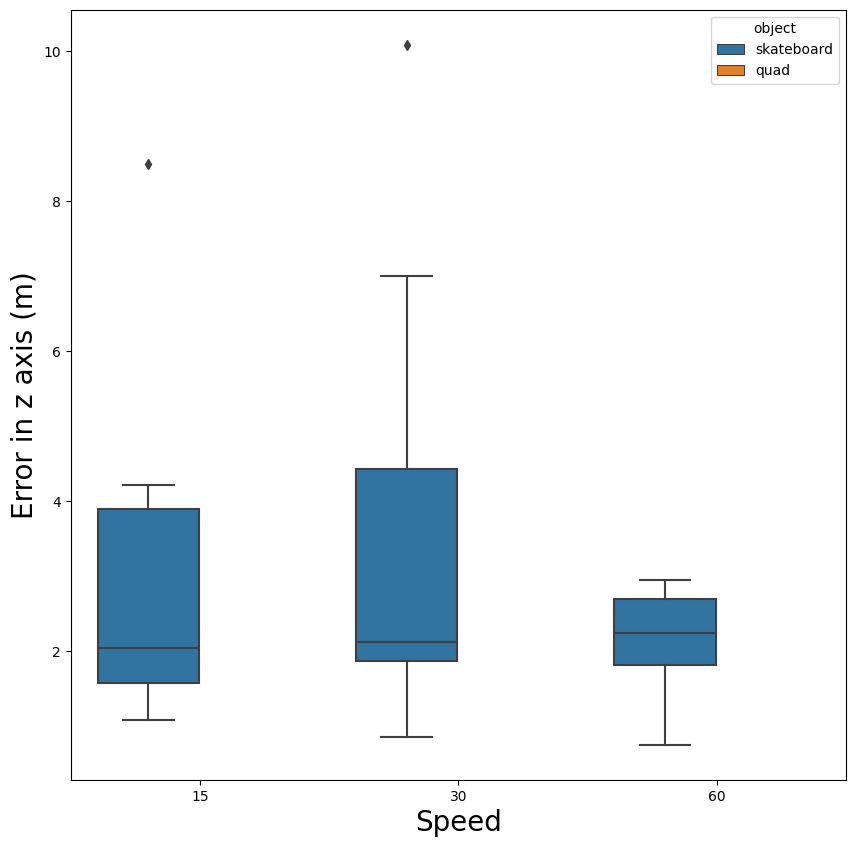

In [9]:
# box plot
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x="fps", y="err_z", hue="object", data=mean_err_df, ax=ax)

# label
ax.set_xlabel("Speed", fontsize=20)
ax.set_ylabel("Error in z axis (m)", fontsize=20)
plt.show()